In [1]:
import tarfile

# Path to your uploaded file
tar_path = "/content/cifar-10-python.tar.gz"

# Open and extract
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path="./cifar-10-batches-py")  # Extract to a folder

print("Extraction completed.")


Extraction completed.


In [3]:
"""
Custom GAN Implementation for CIFAR-10 (Cat vs Dog Classes)
============================================================

This script implements a custom Generative Adversarial Network (GAN) using PyTorch.
The GAN is trained on a subset of the CIFAR-10 dataset, limited to the 'cat' and 'dog' classes.
A modified discriminator is designed to compute the similarity between a real and a generated image
rather than classifying an image as real or fake. The generator learns to produce images similar to real ones.

Author: Zimal Alam
"""


"\nCustom GAN Implementation for CIFAR-10 (Cat vs Dog Classes)\n============================================================\n\nThis script implements a custom Generative Adversarial Network (GAN) using PyTorch.\nThe GAN is trained on a subset of the CIFAR-10 dataset, limited to the 'cat' and 'dog' classes.\nA modified discriminator is designed to compute the similarity between a real and a generated image\nrather than classifying an image as real or fake. The generator learns to produce images similar to real ones.\n\nAuthor: Zimal Alam\n"

In [4]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [22]:
# ----------------------------
# Device Configuration
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Constants
# ----------------------------
CIFAR_PATH = "/content/cifar-10-batches-py/cifar-10-batches-py"
SELECTED_LABELS = {3: 'cat', 5: 'dog'}  # CIFAR-10 label indices for cats and dogs
BATCH_SIZE = 64
EPOCHS = 200
NOISE_DIM = 100


In [23]:
# ----------------------------
# Dataset Utilities
# ----------------------------

def unpickle(file_path):
    """
    Unpickles a CIFAR-10 batch file.

    Args:
        file_path (str): Path to the CIFAR-10 binary file.

    Returns:
        dict: Dictionary containing image data and labels.
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='bytes')
    return data

def load_cifar10(path, selected_labels):
    """
    Loads the CIFAR-10 dataset and filters only selected classes.

    Args:
        path (str): Directory containing CIFAR-10 data batches.
        selected_labels (dict): Dictionary of label indices to include.

    Returns:
        tuple: Numpy arrays of filtered images and corresponding labels.
    """
    all_images, all_labels = [], []
    for i in range(1, 6):
        batch = unpickle(os.path.join(path, f'data_batch_{i}'))
        data = batch[b'data'].reshape(-1, 3, 32, 32)
        labels = np.array(batch[b'labels'])

        mask = np.isin(labels, list(selected_labels.keys()))
        all_images.append(data[mask])
        all_labels.append(labels[mask])

    return np.concatenate(all_images), np.concatenate(all_labels)

class CIFARCatDogDataset(Dataset):
    """
    Custom Dataset for Cat and Dog classes from CIFAR-10.
    Applies transformation and preprocessing.
    """

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        image = np.transpose(image, (1, 2, 0))  # Convert to (H, W, C)
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [24]:
# ----------------------------
# Data Preprocessing
# ----------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

images, labels = load_cifar10(CIFAR_PATH, SELECTED_LABELS)
dataset = CIFARCatDogDataset(images, labels, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

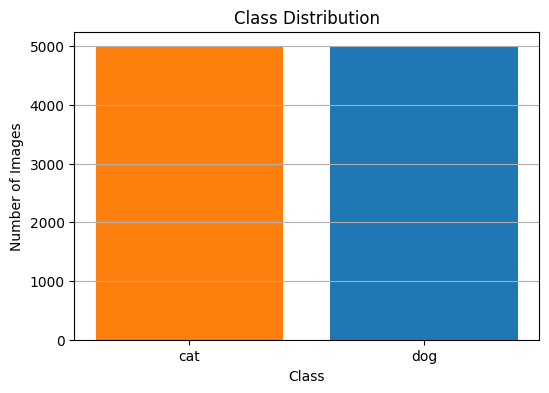

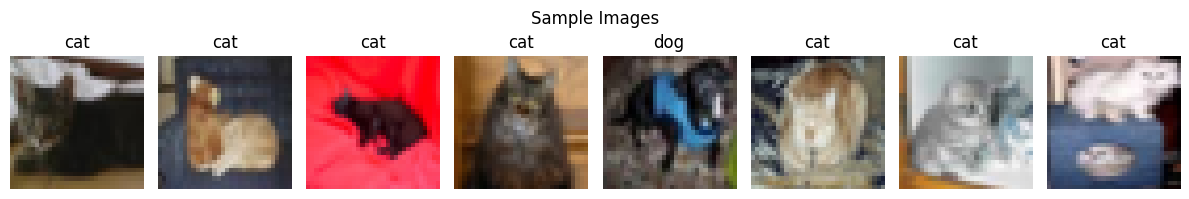

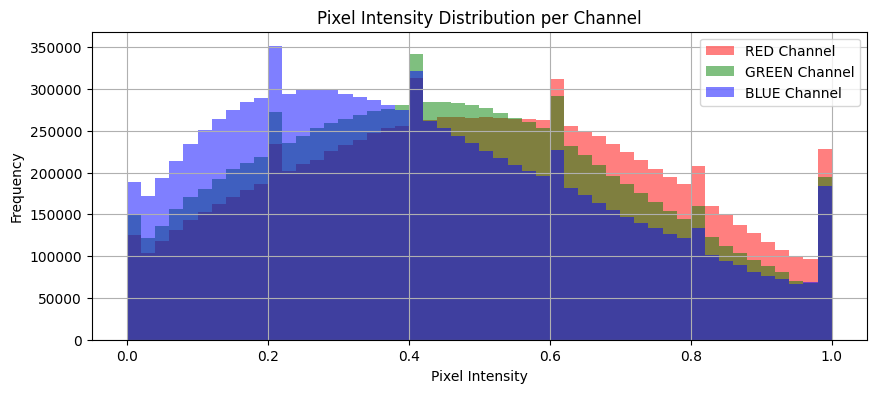

Dataset Mean per Channel: [0.4977044  0.4605248  0.41604242]
Dataset Std  per Channel: [0.25366402 0.24808085 0.25351113]


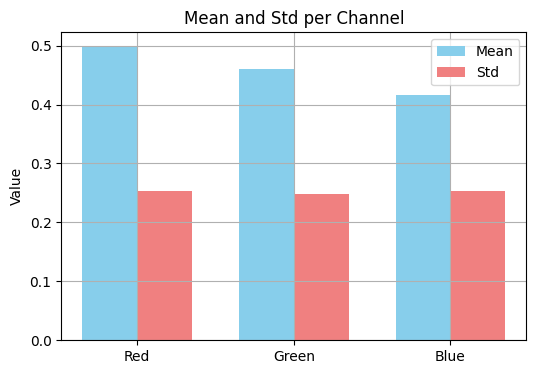

In [36]:
import matplotlib.pyplot as plt
from collections import Counter

# ----------------------------
# EDA: Class Distribution
# ----------------------------
label_names = {3: 'cat', 5: 'dog'}
label_counts = Counter(labels)
mapped_counts = {label_names[k]: v for k, v in label_counts.items()}

plt.figure(figsize=(6, 4))
plt.bar(mapped_counts.keys(), mapped_counts.values(), color=['tab:orange', 'tab:blue'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.grid(axis='y')
plt.show()

# ----------------------------
# EDA: Display Sample Images
# ----------------------------
def show_samples(dataset, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert to HWC
        img = (img * 0.5 + 0.5).numpy()  # Denormalize
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label_names[labels[i]])
        plt.axis('off')
    plt.suptitle("Sample Images")
    plt.tight_layout()
    plt.show()

show_samples(dataset, n=8)

# ----------------------------
# EDA: Pixel Value Histogram
# ----------------------------
all_pixels = images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
plt.figure(figsize=(10, 4))
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    channel_data = all_pixels[:, i, :, :].flatten()
    plt.hist(channel_data, bins=50, alpha=0.5, label=f'{color.upper()} Channel', color=color)
plt.title("Pixel Intensity Distribution per Channel")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# EDA: Mean and Std of Dataset
# ----------------------------
mean = all_pixels.mean(axis=(0, 2, 3))
std = all_pixels.std(axis=(0, 2, 3))

print(f"Dataset Mean per Channel: {mean}")
print(f"Dataset Std  per Channel: {std}")

plt.figure(figsize=(6, 4))
bar_width = 0.35
x = np.arange(3)
plt.bar(x, mean, width=bar_width, label='Mean', color='skyblue')
plt.bar(x + bar_width, std, width=bar_width, label='Std', color='lightcoral')
plt.xticks(x + bar_width / 2, ['Red', 'Green', 'Blue'])
plt.ylabel("Value")
plt.title("Mean and Std per Channel")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# ----------------------------
# Generator Network
# ----------------------------

class Generator(nn.Module):
    """
    Generator Network for creating fake images from random noise.
    Uses linear and transposed convolution layers to upscale noise to image size.
    """
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 8192),
            nn.BatchNorm1d(8192),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# ----------------------------
# Discriminator Network
# ----------------------------

class Discriminator(nn.Module):
    """
    Discriminator Network to compute similarity score between real and generated images.
    Accepts a pair of images and returns a scalar indicating similarity.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(8192, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 1)
        )

    def forward(self, img1, img2):
        x = torch.cat([img1, img2], dim=1)
        return self.model(x)

In [26]:
# ----------------------------
# Model Initialization
# ----------------------------

generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.5, 0.999))
loss_fn = nn.BCEWithLogitsLoss()

In [27]:
# ----------------------------
# Training Loop
# ----------------------------

def train_gan():
    """
    Trains the custom GAN model using the CIFAR-10 cat/dog dataset.
    Generator learns to produce realistic images while discriminator learns to detect dissimilarities.
    """
    for epoch in range(EPOCHS):
        for real_images, _ in dataloader:
            real_images = real_images.to(device, dtype=torch.float32)
            batch_size = real_images.size(0)

            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.full((batch_size, 1), 0.1, device=device)

            # Generate fake images
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_images = generator(noise)

            # Add Gaussian noise for training stability
            real_images_noisy = real_images + 0.1 * torch.randn_like(real_images)
            fake_images_noisy = fake_images + 0.1 * torch.randn_like(fake_images)

            # Discriminator Training
            real_scores = discriminator(real_images_noisy, real_images_noisy)
            fake_scores = discriminator(real_images_noisy, fake_images_noisy)

            d_loss_real = loss_fn(real_scores, real_labels)
            d_loss_fake = loss_fn(fake_scores, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Generator Training (twice per step)
            for _ in range(2):
                noise = torch.randn(batch_size, NOISE_DIM, device=device)
                fake_images = generator(noise)
                fake_scores = discriminator(real_images_noisy, fake_images)

                g_loss = loss_fn(fake_scores, torch.ones_like(fake_scores))

                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()

        print(f"Epoch [{epoch+1}/{EPOCHS}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

In [28]:
# ----------------------------
# Execute Training
# ----------------------------

if __name__ == "__main__":
    train_gan()

Epoch [1/200], D Loss: 0.5155, G Loss: 1.2409
Epoch [2/200], D Loss: 0.4634, G Loss: 1.4162
Epoch [3/200], D Loss: 0.3443, G Loss: 2.2139
Epoch [4/200], D Loss: 0.3318, G Loss: 2.2906
Epoch [5/200], D Loss: 0.3561, G Loss: 2.2396
Epoch [6/200], D Loss: 0.3304, G Loss: 2.2899
Epoch [7/200], D Loss: 0.3449, G Loss: 2.0846
Epoch [8/200], D Loss: 0.3303, G Loss: 2.2372
Epoch [9/200], D Loss: 0.3283, G Loss: 1.9685
Epoch [10/200], D Loss: 0.3302, G Loss: 2.1460
Epoch [11/200], D Loss: 0.3286, G Loss: 2.5525
Epoch [12/200], D Loss: 0.3342, G Loss: 2.3149
Epoch [13/200], D Loss: 0.3296, G Loss: 2.0645
Epoch [14/200], D Loss: 0.3327, G Loss: 2.1638
Epoch [15/200], D Loss: 0.3274, G Loss: 2.2626
Epoch [16/200], D Loss: 0.3282, G Loss: 2.3775
Epoch [17/200], D Loss: 0.3283, G Loss: 2.3593
Epoch [18/200], D Loss: 0.3279, G Loss: 2.3674
Epoch [19/200], D Loss: 0.3284, G Loss: 2.0385
Epoch [20/200], D Loss: 0.3281, G Loss: 2.1806
Epoch [21/200], D Loss: 0.3279, G Loss: 2.2798
Epoch [22/200], D Loss

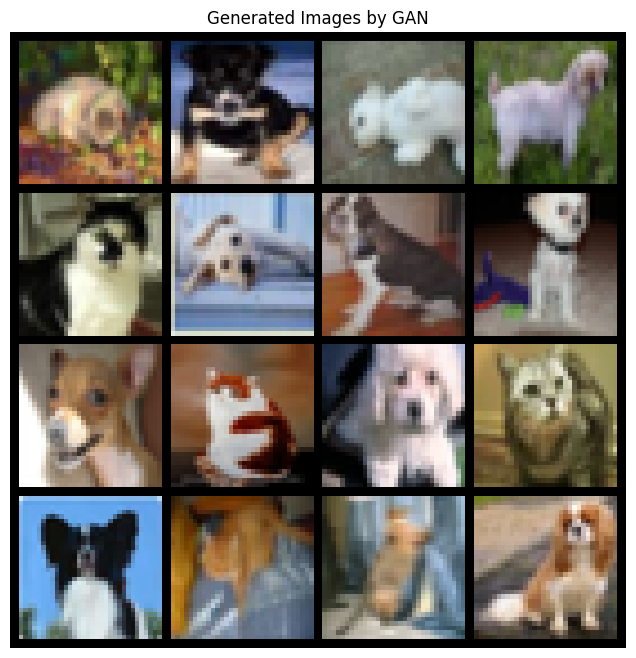

In [35]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def generate_and_visualize_images(generator, noise_dim=100, num_samples=16, device='cpu', save_path="generated_images.png"):
    """
    Generates new images using the trained generator, saves them to disk, and displays them using matplotlib.

    Parameters:
    -----------
    generator : nn.Module
        The trained Generator model.

    noise_dim : int
        Dimensionality of the input noise vector for the generator.

    num_samples : int
        Number of images to generate.

    device : str
        The device on which generation is performed (e.g., 'cpu' or 'cuda').

    save_path : str
        File path where the generated image grid will be saved.

    Returns:
    --------
    None
    """
    # Set the generator to evaluation mode
    generator.eval()

    # Generate random noise vectors
    noise = torch.randn(num_samples, noise_dim, device=device)

    # Generate fake images using the trained generator
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()

    # Save generated images to disk as a grid
    vutils.save_image(fake_images, save_path, normalize=True)
    print(f"Generated images saved as '{save_path}'")

    # Create a grid image for visualization
    grid_img = vutils.make_grid(fake_images, nrow=4, normalize=True).permute(1, 2, 0).numpy()

    # Display the grid of generated images using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img)
    plt.axis("off")
    plt.title("Generated Images from GAN")
    plt.show()

# Example usage
generate_and_visualize_images(generator=generator, noise_dim=100, num_samples=16, device=device)
